In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from wrangle import epl_aq_all
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import regex as re

from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

In [2]:
from preprocessing import preprocessing_script

In [3]:
import sklearn.metrics as m
from sklearn.model_selection import cross_val_score

# Project Goals
1. Create a regression of point differential in predicting future points
2. Analyze the importance of draws in pythagorean expectations predictions
3. Predict by placement (classification) especially on relegation side??

# Wrangle Data
Three functions acquiring and prepping data are all available in wrangle.py file.
- 1. `epl_year_aq`: pulls in data frame from season
- 2. `strip_team_name`: takes in season csv and splits and cleans team_name_column 
- 3. `epl_aq_all`: creates df of all seasons of epl
- 4. `rename columns`: renamess columns explicitly
- 5. `make_number_of_seasons`: makes a column for number of seasons

In [4]:
df = epl_aq_all()

In [5]:
print(df.shape)
df.info()

(340, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   team_name          340 non-null    object
 1   games_played       340 non-null    int64 
 2   wins               340 non-null    int64 
 3   draws              340 non-null    int64 
 4   losses             340 non-null    int64 
 5   goals_for          340 non-null    int64 
 6   goals_against      340 non-null    int64 
 7   goal_differential  340 non-null    int64 
 8   points             340 non-null    int64 
 9   year               340 non-null    int64 
 10  place              340 non-null    int64 
 11  seasons_in_epl     340 non-null    int64 
dtypes: int64(11), object(1)
memory usage: 32.0+ KB


In [6]:
df = preprocessing_script(df)

In [7]:
df

,team_name,games_played,wins,draws,losses,goals_for,goals_against,goal_differential,points,year,place,seasons_in_epl,finish,next_season_points,goal_percentage,win_rate,surpluss_goals,points_rate,goals_per_loss
0,AFC Bournemouth,38,11,9,18,45,67,-22,42,2015,16,4,relegation_battle,46.0,0.401786,0.611111,-33,1.111111,2.500000
1,AFC Bournemouth,38,12,10,16,55,67,-12,46,2016,9,4,mid_table,44.0,0.450820,0.750000,-24,1.375000,3.437500
2,AFC Bournemouth,38,11,11,16,45,61,-16,44,2017,12,4,mid_table,45.0,0.424528,0.687500,-27,1.375000,2.812500
3,AFC Bournemouth,38,13,6,19,56,70,-14,45,2018,14,4,mid_table,NaN,0.444444,0.684211,-27,1.000000,2.947368
4,Arsenal,38,23,9,6,85,42,43,78,2002,2,17,champions_league,90.0,0.669291,3.833333,20,5.333333,14.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,Wolverhampton Wanderers,38,7,12,19,38,77,-39,33,2003,20,5,relegation,38.0,0.330435,0.368421,-46,1.000000,2.000000
336,Wolverhampton Wanderers,38,9,11,18,32,56,-24,38,2009,15,5,relegation_battle,40.0,0.363636,0.500000,-33,1.111111,1.777778
337,Wolverhampton Wanderers,38,11,7,20,46,66,-20,40,2010,17,5,relegation_battle,25.0,0.410714,0.550000,-31,0.900000,2.300000
338,Wolverhampton Wanderers,38,5,10,23,40,82,-42,25,2011,20,5,relegation,57.0,0.327869,0.217391,-47,0.652174,1.739130


In [8]:
df['next_year'] = df.year.shift(-1)

In [9]:
(df[['points', 'goal_differential', 'next_season_points', 
     'wins', 'goals_for', 'goals_against', 'place', 'losses', 
     'goal_percentage', 'win_rate', 'surpluss_goals', 'points_rate',
    'goals_per_loss', 'seasons_in_epl']]
     .dropna().corr().next_season_points)

points                0.784466
goal_differential     0.808551
next_season_points    1.000000
wins                  0.760709
goals_for             0.752497
goals_against        -0.699766
place                -0.726295
losses               -0.770751
goal_percentage       0.816789
win_rate              0.571873
surpluss_goals        0.805589
points_rate           0.567617
goals_per_loss        0.604209
seasons_in_epl        0.638860
Name: next_season_points, dtype: float64

#### Overview of the dataframe

In [10]:
print(df.shape)
print(df.info())
df.head(2)

(340, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 20 columns):
team_name             340 non-null object
games_played          340 non-null int64
wins                  340 non-null int64
draws                 340 non-null int64
losses                340 non-null int64
goals_for             340 non-null int64
goals_against         340 non-null int64
goal_differential     340 non-null int64
points                340 non-null int64
year                  340 non-null int64
place                 340 non-null int64
seasons_in_epl        340 non-null int64
finish                340 non-null object
next_season_points    300 non-null float64
goal_percentage       340 non-null float64
win_rate              340 non-null float64
surpluss_goals        340 non-null int64
points_rate           340 non-null float64
goals_per_loss        340 non-null float64
next_year             339 non-null float64
dtypes: float64(6), int64(12), object(2)
memory usa

,team_name,games_played,wins,draws,losses,goals_for,goals_against,goal_differential,points,year,place,seasons_in_epl,finish,next_season_points,goal_percentage,win_rate,surpluss_goals,points_rate,goals_per_loss,next_year
0,AFC Bournemouth,38,11,9,18,45,67,-22,42,2015,16,4,relegation_battle,46.0,0.401786,0.611111,-33,1.111111,2.5000,2016.0
1,AFC Bournemouth,38,12,10,16,55,67,-12,46,2016,9,4,mid_table,44.0,0.450820,0.750000,-24,1.375000,3.4375,2017.0


In [11]:
df.describe()

,games_played,wins,draws,losses,goals_for,goals_against,goal_differential,points,year,place,seasons_in_epl,next_season_points,goal_percentage,win_rate,surpluss_goals,points_rate,goals_per_loss,next_year
count,340.0,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.0000,340.00000,340.000000,300.000000,340.000000,340.000000,340.000000,340.000000,340.000000,339.000000
mean,38.0,14.235294,9.529412,14.235294,50.758824,50.758824,0.000000,52.208824,2010.0000,10.50000,11.941176,53.196667,0.497100,inf,-14.235294,inf,inf,2009.985251
std,0.0,6.023841,2.819394,5.595820,15.492335,13.182430,25.948667,17.242002,4.9062,5.77478,4.839861,17.325277,0.122980,NaN,20.319075,NaN,NaN,4.905897
min,38.0,1.000000,2.000000,0.000000,20.000000,15.000000,-69.000000,11.000000,2002.0000,1.00000,1.000000,15.000000,0.183486,0.034483,-70.000000,0.310345,0.689655,2002.000000
25%,38.0,10.000000,7.000000,10.000000,41.000000,41.750000,-18.250000,40.000000,2006.0000,5.75000,7.750000,41.000000,0.408303,0.554167,-28.000000,1.111111,2.280952,2006.000000
50%,38.0,13.000000,9.000000,15.000000,47.000000,51.000000,-7.000000,47.500000,2010.0000,10.50000,13.000000,48.500000,0.465347,0.806250,-19.000000,1.533333,3.000000,2010.000000
75%,38.0,18.000000,11.000000,18.000000,59.000000,59.000000,16.500000,63.000000,2014.0000,15.25000,17.000000,64.250000,0.583726,1.771368,-0.750000,2.800000,5.706818,2014.000000
max,38.0,32.000000,17.000000,29.000000,106.000000,89.000000,79.000000,100.000000,2018.0000,20.00000,17.000000,100.000000,0.827586,inf,47.000000,inf,inf,2018.000000


# Explore

## Are goals per game increasing over time?

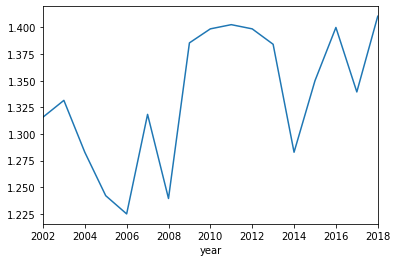

In [12]:
(df.groupby('year').goals_for.mean()/38).plot()

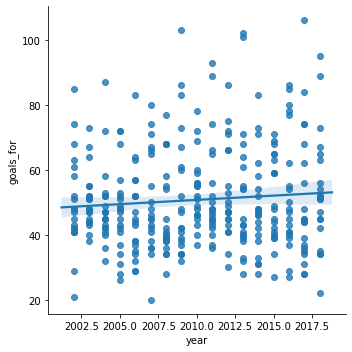

In [13]:
sns.lmplot(x='year', y='goals_for', data=df)

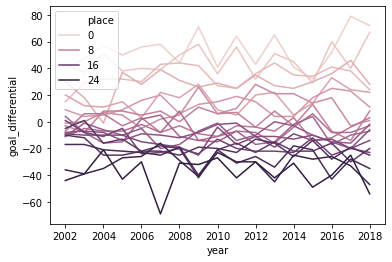

In [14]:
sns.lineplot(x ='year', y ='goal_differential', data=df, hue='place')

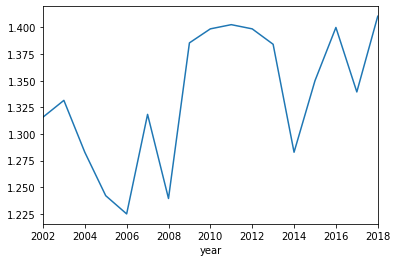

In [15]:
(df.groupby('year').goals_against.mean()/38).plot()

### Team Results

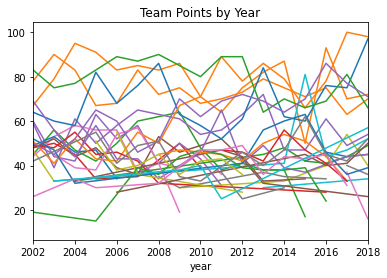

In [16]:
df.set_index('year').groupby('team_name').points.plot()
plt.title('Team Points by Year')
plt.show()

**Takeaways** At the top of the viz, you can see that there are a couple teams that have stayed at the top of the table, but as you get further towards the middle, the data becomes a lot more muddled

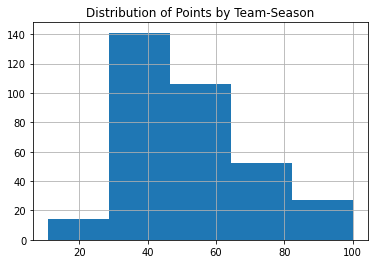

In [17]:
df.points.hist(bins=5)
plt.title("Distribution of Points by Team-Season")
plt.show()

**Takeaways** Looks like a poisson distribution.

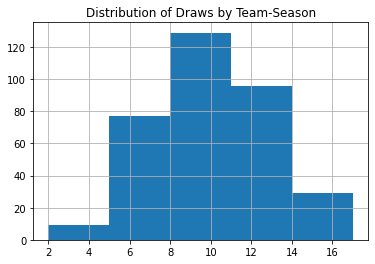

In [18]:
df.draws.hist(bins=5)
plt.title("Distribution of Draws by Team-Season")
plt.show()

**Takeaways** Normal distribution around 9-10 draws per season

In [19]:
df.draws.describe()

count    340.000000
mean       9.529412
std        2.819394
min        2.000000
25%        7.000000
50%        9.000000
75%       11.000000
max       17.000000
Name: draws, dtype: float64

Average number of draws per year is 9.5

### Exploring Draws a little more closely

Text(0.5, 1.0, 'Is There a Pattern for Draws by Table Place?')

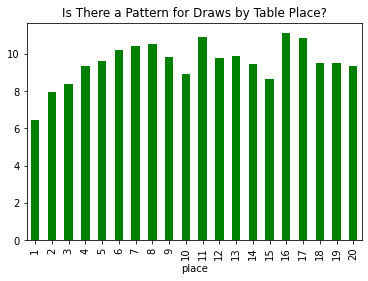

In [20]:
df.groupby('place').draws.mean().plot.bar(color='green')
plt.title('Is There a Pattern for Draws by Table Place?')

**Takeaways** Number of draws tend to be higher at the middle of the table

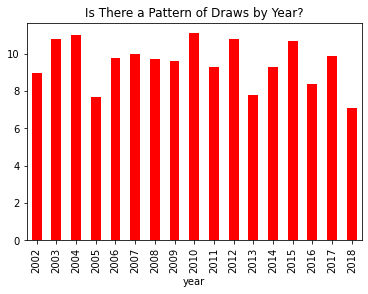

In [21]:
df.groupby('year').draws.mean().plot.bar(color='red')
plt.title('Is There a Pattern of Draws by Year?')
plt.show()

**Takeaways** Not really, there is a pretty significant difference between certain years, but no noticeable trends
**Furtherwork** Some hypothesis testing and statistical analysis

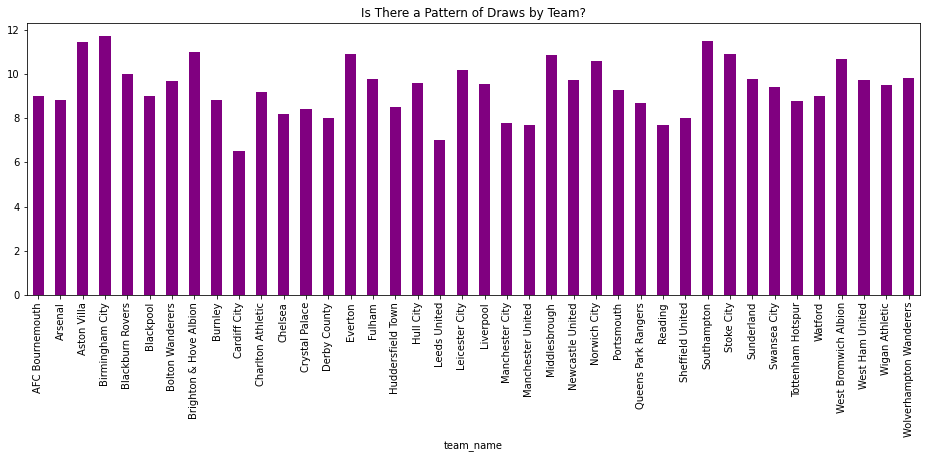

In [22]:
plt.figure(figsize=(16,5))
df.groupby('team_name').draws.mean().plot.bar(color='purple')
plt.title('Is There a Pattern of Draws by Team?')
plt.show()

**Takeaways** Likely, but not immediately evident.

Text(0.5, 1.0, 'Because of Relegation, How Many Seasons Has Each Team Played?')

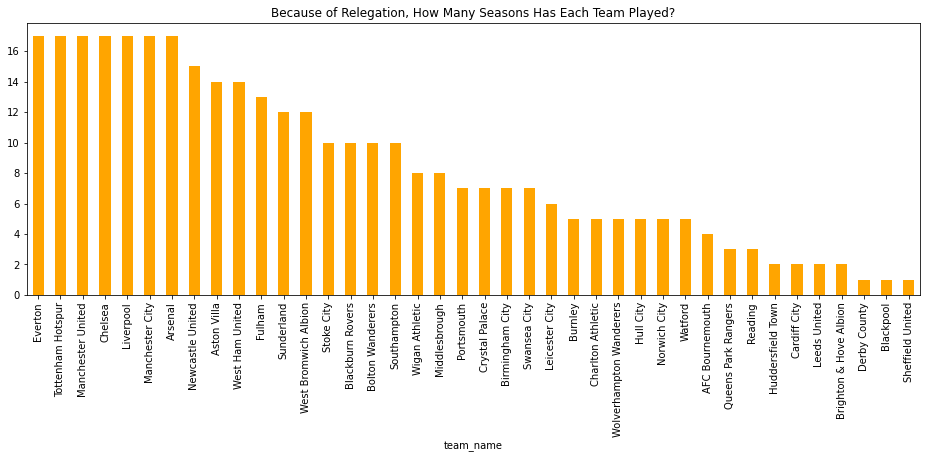

In [23]:
plt.figure(figsize=(16,5))
df.groupby('team_name').draws.count().sort_values(ascending=False).plot.bar(color='orange')
plt.title('Because of Relegation, How Many Seasons Has Each Team Played?')

### Just for fun , lets look at scatter plots of number of seasons and average number of points and draws!

Text(0.5, 1.0, 'What is the Relationship between No of Seasons in EPL and Avg No of Draws')

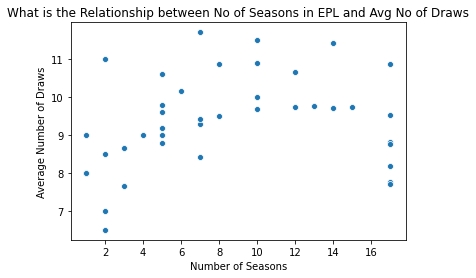

In [24]:
df_temp = df.groupby('team_name').draws.agg(['count', 'mean'])
sns.scatterplot(x='count', y='mean', data=df_temp)
plt.xlabel('Number of Seasons')
plt.ylabel('Average Number of Draws')
plt.title('What is the Relationship between No of Seasons in EPL and Avg No of Draws')

Text(0.5, 1.0, 'What is the Relationship between No of Seasons in EPL and Avg Points')

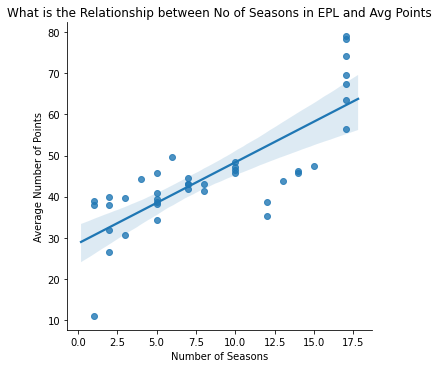

In [25]:
df_temp = df.groupby('team_name').points.agg(['count', 'mean'])
sns.lmplot(x='count', y='mean', data=df_temp)
plt.xlabel('Number of Seasons')
plt.ylabel('Average Number of Points')
plt.title('What is the Relationship between No of Seasons in EPL and Avg Points')

**Takeaways:** Seems to be a pretty clear linear relationship between number of seasons in the Premier League and the Average number of Points

Text(0.5, 1.0, 'What is the relationship between points and goal differential')

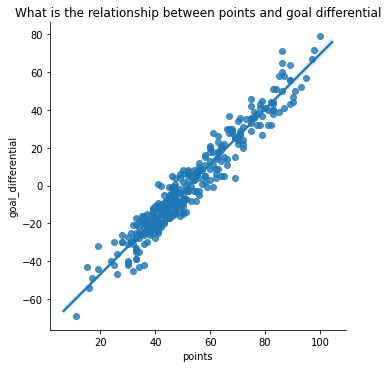

In [26]:
sns.lmplot(x='points', y = 'goal_differential', data = df)
plt.title('What is the relationship between points and goal differential')

Text(0.5, 1.0, 'What is the relationship between points and place')

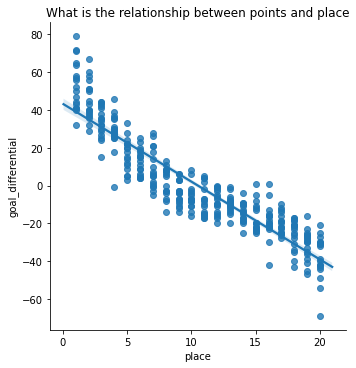

In [27]:
sns.lmplot(x='place', y = 'goal_differential', data = df)
plt.title('What is the relationship between points and place')

### Is it better to win or avoid a loss?

Text(0, 0.5, 'Absolute value of correlation')

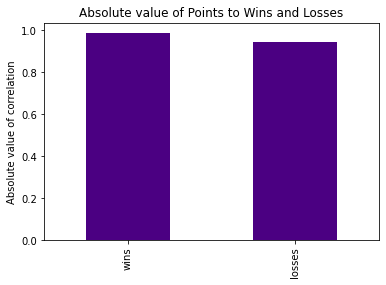

In [28]:
df[['wins', 'losses', 'points']].corr().points[0:2].abs().plot.bar(color='indigo')
plt.title("Absolute value of Points to Wins and Losses")
plt.ylabel('Absolute value of correlation')

**Takeaways:** Although there is a high absolute correlation to both.  It appears that winning is more important than avoiding losses.

Text(0, 0.5, 'Absolute value of correlation')

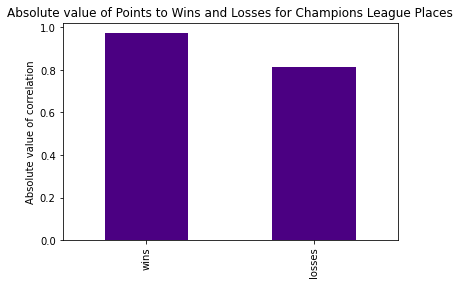

In [29]:
df[df.place <= 4][['wins', 'losses', 'points']].corr().points[0:2].abs().plot.bar(color='indigo')
plt.title("Absolute value of Points to Wins and Losses for Champions League Places")
plt.ylabel('Absolute value of correlation')

Text(0, 0.5, 'Absolute value of correlation')

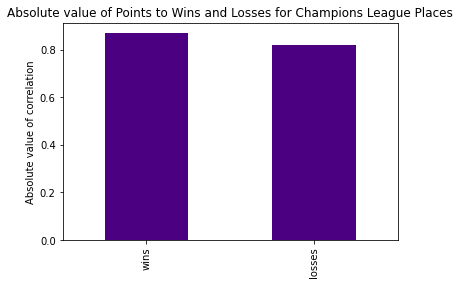

In [30]:
df[df.place >= 18][['wins', 'losses', 'points']].corr().points[0:2].abs().plot.bar(color='indigo')
plt.title("Absolute value of Points to Wins and Losses for Champions League Places")
plt.ylabel('Absolute value of correlation')

# Modeling

In [31]:
df.head()

,team_name,games_played,wins,draws,losses,goals_for,goals_against,goal_differential,points,year,place,seasons_in_epl,finish,next_season_points,goal_percentage,win_rate,surpluss_goals,points_rate,goals_per_loss,next_year
0,AFC Bournemouth,38,11,9,18,45,67,-22,42,2015,16,4,relegation_battle,46.0,0.401786,0.611111,-33,1.111111,2.500000,2016.0
1,AFC Bournemouth,38,12,10,16,55,67,-12,46,2016,9,4,mid_table,44.0,0.450820,0.750000,-24,1.375000,3.437500,2017.0
2,AFC Bournemouth,38,11,11,16,45,61,-16,44,2017,12,4,mid_table,45.0,0.424528,0.687500,-27,1.375000,2.812500,2018.0
3,AFC Bournemouth,38,13,6,19,56,70,-14,45,2018,14,4,mid_table,NaN,0.444444,0.684211,-27,1.000000,2.947368,2002.0
4,Arsenal,38,23,9,6,85,42,43,78,2002,2,17,champions_league,90.0,0.669291,3.833333,20,5.333333,14.166667,2003.0


In [32]:



df_pred = df[(df.year - (df.next_year - 1)) == 0]

In [33]:
print(df_pred.shape)
df_pred.info()

(272, 20)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 272 entries, 0 to 337
Data columns (total 20 columns):
team_name             272 non-null object
games_played          272 non-null int64
wins                  272 non-null int64
draws                 272 non-null int64
losses                272 non-null int64
goals_for             272 non-null int64
goals_against         272 non-null int64
goal_differential     272 non-null int64
points                272 non-null int64
year                  272 non-null int64
place                 272 non-null int64
seasons_in_epl        272 non-null int64
finish                272 non-null object
next_season_points    272 non-null float64
goal_percentage       272 non-null float64
win_rate              272 non-null float64
surpluss_goals        272 non-null int64
points_rate           272 non-null float64
goals_per_loss        272 non-null float64
next_year             272 non-null float64
dtypes: float64(6), int64(12), object(2)
memory usa

In [34]:
predictions = pd.DataFrame({
    'yhat': df_pred['next_season_points']
})

In [35]:
lm = LinearRegression()

In [36]:
X = df_pred[['points']]
y = df_pred[['next_season_points']]

In [37]:
lm.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [38]:
predictions['pred_points'] = lm.predict(y)

In [39]:
predictions

,yhat,pred_points
0,46.0,46.089526
1,44.0,44.349816
2,45.0,45.219671
4,90.0,84.363134
5,83.0,78.274151
...,...,...
331,42.0,42.610107
332,43.0,43.479962
333,36.0,37.390979
336,40.0,40.870398


In [40]:
lm.score(X, y)

0.6062767347880587

In [8]:
df

,team_name,games_played,wins,draws,losses,goals_for,goals_against,goal_differential,points,year,place,seasons_in_epl,finish,next_season_points,goal_percentage,win_rate,surpluss_goals,points_rate,goals_per_loss
0,AFC Bournemouth,38,11,9,18,45,67,-22,42,2015,16,4,relegation_battle,46.0,0.401786,0.611111,-33,1.111111,2.500000
1,AFC Bournemouth,38,12,10,16,55,67,-12,46,2016,9,4,mid_table,44.0,0.450820,0.750000,-24,1.375000,3.437500
2,AFC Bournemouth,38,11,11,16,45,61,-16,44,2017,12,4,mid_table,45.0,0.424528,0.687500,-27,1.375000,2.812500
3,AFC Bournemouth,38,13,6,19,56,70,-14,45,2018,14,4,mid_table,NaN,0.444444,0.684211,-27,1.000000,2.947368
4,Arsenal,38,23,9,6,85,42,43,78,2002,2,17,champions_league,90.0,0.669291,3.833333,20,5.333333,14.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,Wolverhampton Wanderers,38,7,12,19,38,77,-39,33,2003,20,5,relegation,38.0,0.330435,0.368421,-46,1.000000,2.000000
336,Wolverhampton Wanderers,38,9,11,18,32,56,-24,38,2009,15,5,relegation_battle,40.0,0.363636,0.500000,-33,1.111111,1.777778
337,Wolverhampton Wanderers,38,11,7,20,46,66,-20,40,2010,17,5,relegation_battle,25.0,0.410714,0.550000,-31,0.900000,2.300000
338,Wolverhampton Wanderers,38,5,10,23,40,82,-42,25,2011,20,5,relegation,57.0,0.327869,0.217391,-47,0.652174,1.739130


In [10]:
for i in range(len(df.index)):
    print(df[i])

KeyError: 0

In [41]:
features_for_modeling = df_pred.drop(columns=['team_name', 'games_played', 'year', 'next_season_points', 'finish', 'win_rate', 'points_rate', 'goals_per_loss', 'next_year']).columns

In [42]:
features_for_modeling

Index(['wins', 'draws', 'losses', 'goals_for', 'goals_against',
       'goal_differential', 'points', 'place', 'seasons_in_epl',
       'goal_percentage', 'surpluss_goals'],
      dtype='object')

In [43]:
for i in features_for_modeling:
    X = df_pred[[i]]
    y = df_pred[['next_season_points']]
    lm.fit(X, y)
    predictions[f'pred_{i}'] = lm.predict(X)

In [44]:
predictions

,yhat,pred_points,pred_wins,pred_draws,pred_losses,pred_goals_for,pred_goals_against,pred_goal_differential,pred_place,pred_seasons_in_epl,pred_goal_percentage,pred_surpluss_goals
0,46.0,42.610107,44.314731,55.338619,41.041964,47.795041,33.642099,38.412073,36.841452,32.597701,39.393851,37.298893
1,44.0,46.089526,46.670355,54.387229,46.417631,56.291642,33.642099,44.339175,54.698529,32.597701,45.568149,44.086831
2,45.0,44.349816,44.314731,53.435839,46.417631,47.795041,40.170232,41.968335,47.045496,32.597701,42.257571,41.824185
4,90.0,73.924877,72.582218,55.338619,73.295966,81.781445,60.842655,76.938236,72.555607,65.118937,73.077840,77.272304
5,83.0,84.363134,79.649090,52.484450,89.422967,71.585524,78.251011,79.309077,75.106618,65.118937,81.650695,78.026519
...,...,...,...,...,...,...,...,...,...,...,...,...
331,42.0,37.390979,39.603484,55.338619,35.666297,40.997761,20.585831,26.557869,36.841452,42.604235,28.965231,23.723018
332,43.0,42.610107,39.603484,49.630280,51.793298,43.546741,40.170232,39.004784,36.841452,42.604235,38.670308,39.561539
333,36.0,43.479962,44.314731,54.387229,43.729797,45.246061,39.082210,39.597494,39.392463,42.604235,39.653299,38.807324
336,40.0,39.130688,39.603484,53.435839,41.041964,36.749460,45.610343,37.226653,39.392463,35.099334,34.590130,37.298893


In [45]:
prediction_features = predictions.drop(columns=('yhat')).columns

In [46]:
#determining rmse
score = []
for i in prediction_features:
    name = i
    rmse = ((predictions.yhat - predictions[i])**2).mean()**.5
    score.append(rmse)

In [47]:
pd.DataFrame({
    'feature': list(prediction_features),
    'rmse': score
})

,feature,rmse
0,pred_points,10.819660
1,pred_wins,11.348327
2,pred_draws,17.037425
3,pred_losses,11.177875
4,pred_goals_for,11.703273
5,pred_goals_against,12.218897
6,pred_goal_differential,10.238329
7,pred_place,11.880423
8,pred_seasons_in_epl,13.302658
9,pred_goal_percentage,10.077901


## Cross Validation

In [48]:
import sklearn.metrics as m
from sklearn.model_selection import cross_val_score

In [49]:
for i in features_for_modeling:
    X = df_pred[i]
    y = df_pred['points']
    print(f'{i} is {cross_val_score(lm, X, y, cv=2)}')

wins is [nan nan]
draws is [nan nan]
losses is [nan nan]
goals_for is [nan nan]
goals_against is [nan nan]
goal_differential is [nan nan]
points is [nan nan]
place is [nan nan]
seasons_in_epl is [nan nan]
goal_percentage is [nan nan]
surpluss_goals is [nan nan]


In [50]:
df_pred

,team_name,games_played,wins,draws,losses,goals_for,goals_against,goal_differential,points,year,place,seasons_in_epl,finish,next_season_points,goal_percentage,win_rate,surpluss_goals,points_rate,goals_per_loss,next_year
0,AFC Bournemouth,38,11,9,18,45,67,-22,42,2015,16,4,relegation_battle,46.0,0.401786,0.611111,-33,1.111111,2.500000,2016.0
1,AFC Bournemouth,38,12,10,16,55,67,-12,46,2016,9,4,mid_table,44.0,0.450820,0.750000,-24,1.375000,3.437500,2017.0
2,AFC Bournemouth,38,11,11,16,45,61,-16,44,2017,12,4,mid_table,45.0,0.424528,0.687500,-27,1.375000,2.812500,2018.0
4,Arsenal,38,23,9,6,85,42,43,78,2002,2,17,champions_league,90.0,0.669291,3.833333,20,5.333333,14.166667,2003.0
5,Arsenal,38,26,12,0,73,26,47,90,2003,1,17,champions_league,83.0,0.737374,inf,21,inf,inf,2004.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,Wigan Athletic,38,9,9,20,37,79,-42,36,2009,16,8,relegation_battle,42.0,0.318966,0.450000,-51,0.900000,1.850000,2010.0
332,Wigan Athletic,38,9,15,14,40,61,-21,42,2010,16,8,relegation_battle,43.0,0.396040,0.642857,-30,1.714286,2.857143,2011.0
333,Wigan Athletic,38,11,10,17,42,62,-20,43,2011,15,8,relegation_battle,36.0,0.403846,0.647059,-31,1.235294,2.470588,2012.0
336,Wolverhampton Wanderers,38,9,11,18,32,56,-24,38,2009,15,5,relegation_battle,40.0,0.363636,0.500000,-33,1.111111,1.777778,2010.0


In [51]:
df_pred

,team_name,games_played,wins,draws,losses,goals_for,goals_against,goal_differential,points,year,place,seasons_in_epl,finish,next_season_points,goal_percentage,win_rate,surpluss_goals,points_rate,goals_per_loss,next_year
0,AFC Bournemouth,38,11,9,18,45,67,-22,42,2015,16,4,relegation_battle,46.0,0.401786,0.611111,-33,1.111111,2.500000,2016.0
1,AFC Bournemouth,38,12,10,16,55,67,-12,46,2016,9,4,mid_table,44.0,0.450820,0.750000,-24,1.375000,3.437500,2017.0
2,AFC Bournemouth,38,11,11,16,45,61,-16,44,2017,12,4,mid_table,45.0,0.424528,0.687500,-27,1.375000,2.812500,2018.0
4,Arsenal,38,23,9,6,85,42,43,78,2002,2,17,champions_league,90.0,0.669291,3.833333,20,5.333333,14.166667,2003.0
5,Arsenal,38,26,12,0,73,26,47,90,2003,1,17,champions_league,83.0,0.737374,inf,21,inf,inf,2004.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,Wigan Athletic,38,9,9,20,37,79,-42,36,2009,16,8,relegation_battle,42.0,0.318966,0.450000,-51,0.900000,1.850000,2010.0
332,Wigan Athletic,38,9,15,14,40,61,-21,42,2010,16,8,relegation_battle,43.0,0.396040,0.642857,-30,1.714286,2.857143,2011.0
333,Wigan Athletic,38,11,10,17,42,62,-20,43,2011,15,8,relegation_battle,36.0,0.403846,0.647059,-31,1.235294,2.470588,2012.0
336,Wolverhampton Wanderers,38,9,11,18,32,56,-24,38,2009,15,5,relegation_battle,40.0,0.363636,0.500000,-33,1.111111,1.777778,2010.0


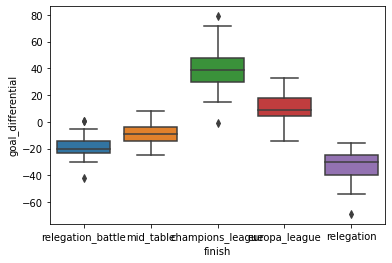

In [54]:
sns.boxplot(x='finish', y='goal_differential', data=df)